In [66]:

import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pickle



In [67]:

# 1. Load Data
df = pd.read_csv("UCI_Credit_Card.csv")

# 2. Data Cleaning
# Drop ID 
df.drop('ID', axis=1, inplace=True)

# Drop PAY_5, PAY_6 and corresponding BILL_AMT and PAY_AMT
df.drop(columns=["PAY_5", "PAY_6", "BILL_AMT5", "BILL_AMT6", "PAY_AMT5", "PAY_AMT6"], inplace=True)

# Check for missing values
assert df.isnull().sum().sum() == 0, "Missing values detected!"
df.head(5)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,default
0,20000.0,2,2,1,24,2,2,-1,-1,3913.0,3102.0,689.0,0.0,0.0,689.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,2682.0,1725.0,2682.0,3272.0,0.0,1000.0,1000.0,1000.0,1
2,90000.0,2,2,2,34,0,0,0,0,29239.0,14027.0,13559.0,14331.0,1518.0,1500.0,1000.0,1000.0,0
3,50000.0,2,2,1,37,0,0,0,0,46990.0,48233.0,49291.0,28314.0,2000.0,2019.0,1200.0,1100.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,8617.0,5670.0,35835.0,20940.0,2000.0,36681.0,10000.0,9000.0,0


In [68]:

# 3. Feature Selection / Preprocessing


X = df.drop("default", axis=1)
y = df["default"]

# Normalize continuous variables (amounts, bill, payments)
amount_features = [
    "LIMIT_BAL", *[f"BILL_AMT{i}" for i in range(1,5)], *[f"PAY_AMT{i}" for i in range(1, 5)]
]
scaler = StandardScaler()
X[amount_features] = scaler.fit_transform(X[amount_features])
# Save the fitted scaler
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)



In [69]:
print('Features : ',X.columns.tolist())
print('Target : ',y.name)

Features :  ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4']
Target :  default


In [70]:

# 4. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)


In [71]:
# 5. Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [8, 10, 12],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced']
}
gs = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='roc_auc')
gs.fit(X_train, y_train)
rf = gs.best_estimator_


In [72]:
# 6. Evaluation
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

print("=== Classification Report ===")
print(classification_report(y_test, y_pred))



print("\n=== ROC-AUC Score ===")
print(roc_auc_score(y_test, y_proba))


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.88      0.83      0.85      5841
           1       0.50      0.58      0.54      1659

    accuracy                           0.78      7500
   macro avg       0.69      0.71      0.70      7500
weighted avg       0.79      0.78      0.78      7500


=== ROC-AUC Score ===
0.7757842211822044



=== Confusion Matrix ===
[[4871  970]
 [ 692  967]]


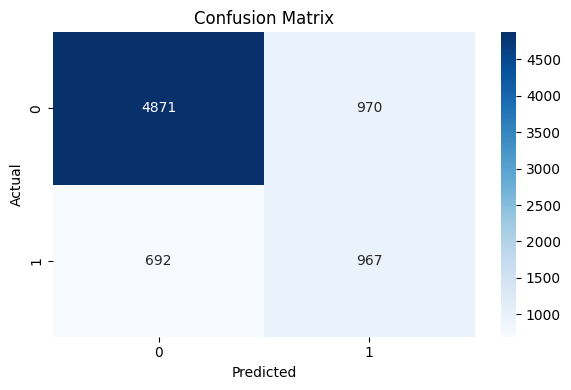

In [73]:
# 7. Confusion Matrix Heatmap
print("\n=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

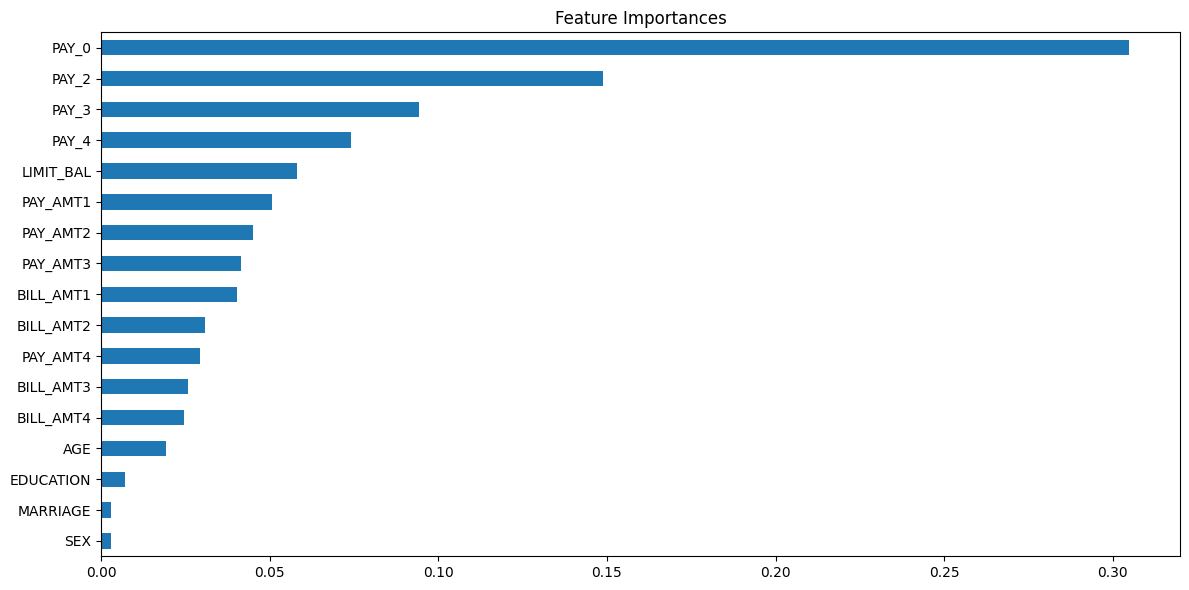

In [74]:

# 8. Feature Importance
plt.figure(figsize=(12, 6))
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh')
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

In [75]:

# 10. Export Model with Pickle
with open("credit_rf_model.pkl", "wb") as f:
    pickle.dump(rf, f)
